# Milk adulteration

```
题目： 基于拉曼光谱和k最近邻回归的羊奶掺假判别方法

摘要 Abstract
近年来，随着人们对营养及健康的重视，人们在乳制品的选择方面更倾向于选择羊奶来代替牛奶。然而，一些不良商家为了牟取暴利，在羊奶中掺假掺杂。采用拉曼光谱分析法检测羊奶中牛奶的含量，以0%、1%、2%、5%、10%、20%、40%、 60%、80%、100%的掺假率构建不同的样本。以掺假率作为预测目标，设计了基于K-最近邻回归模型的掺假判别模型。该模型与常用的线性回归和支持向量回归器等进行了对比，取得了预测最优效果。在测试集上的预测R2效应量分别为。。。。本文提供了一种快速、高效、准确的羊奶掺假的判别技术。。。 

图文摘要 Graphical abstract
放整体研究和方法框架

1.简介 Introduction
背景、羊奶vs牛奶，羊奶掺假问题、现有判别技术。。。，引出拉曼光谱的优势

2.材料与方法 Materials and methods
2.1.样品采集与制备 Samples collection and preparation
羊奶牛奶的来源、如何掺假
2.2拉曼光谱分析 Raman spectral analysis
介绍仪器
数据集描述性统计； 绘制不同掺假比例羊奶牛奶的平均波形
2.3预测模型
KNR原理介绍，特点/优势/缺点等

3.结果与讨论 Results and discussion


3.1数据分割 Data Splitting
Stratified Kennardstone Split

3.2 线性回归 / Ridge / LASSO / SVR / RF / KNR
介绍，分析
超参数如何选择

4.结论 Conclusions
什么方法效果比较好、
回扣背景问题，研究的意义

致谢 Acknowledgments
参考文献 References

```

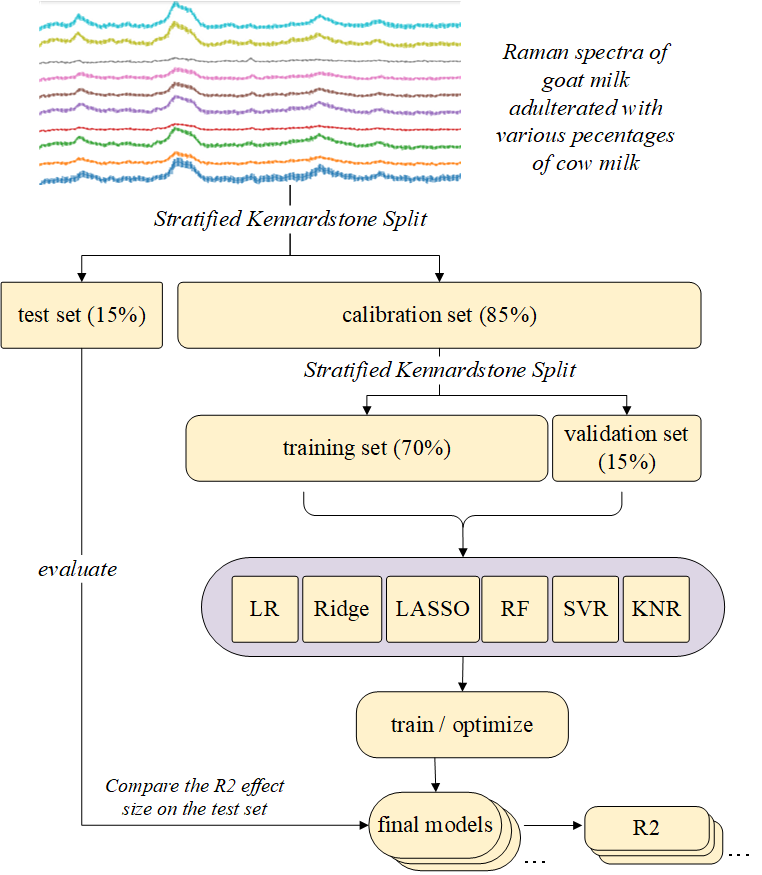

比例更新

In [1]:
import qsi
qsi.__version__

'1.4.0'

load dataset from adulteration.CSV
X.shape (500, 1300)  y.shape (500,)


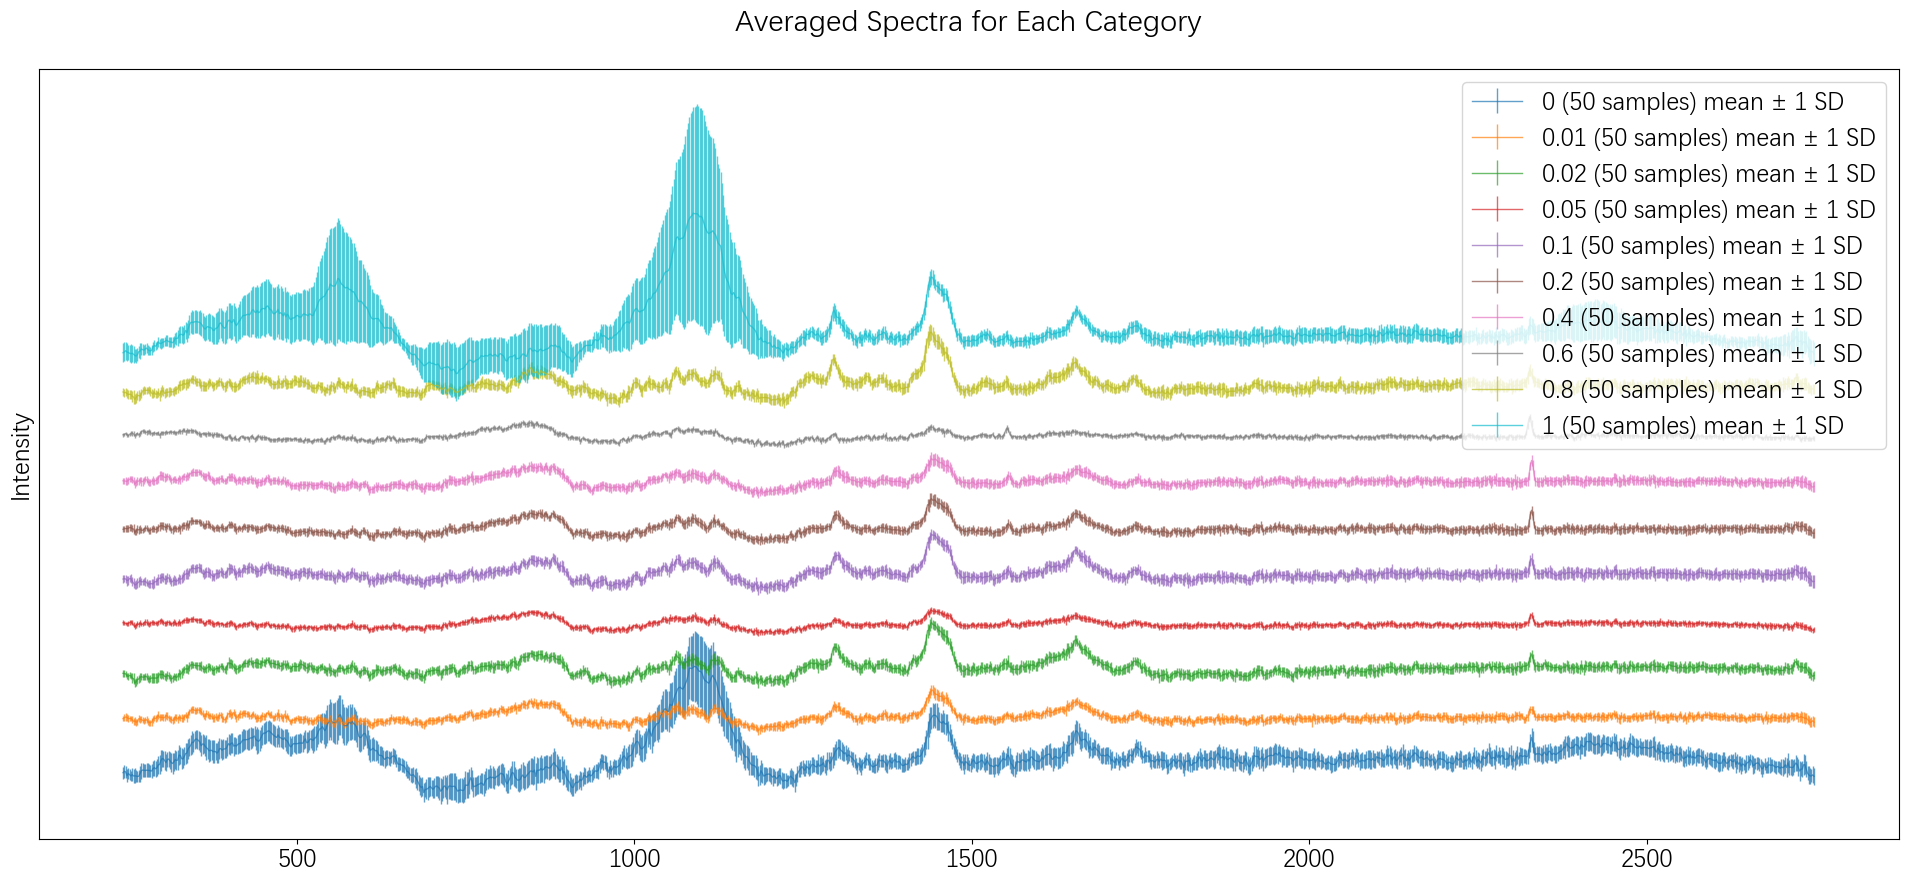

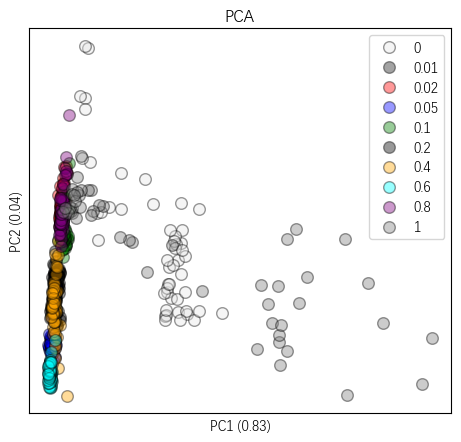

Raman spectra of goat milk adultered with different percentages of cow milk.

yangniu0% label=0
yangniu1% label=1
yangniu2% label=2
yangniu5% label=3
yangniu10% label=4
yangniu20% label=5
yangniu40% label=6
yangniu60% label=7
yangniu80% label=8
yangniu100% label=9

"Goat milk is higher in fat and calories when compared to cow milk, and it also contains more protein, vitamins and minerals. 
When compared, goat milk also has about 1% less lactose than cow milk."
goats' milk is almost five times as expensive as cows' milk.  

The goat milk is from M company (Mengyang) and the cow milk is from T company (Telunsu).
No module named 'rpy2'


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10000000.0, residual penalty asymetry = 0.01)


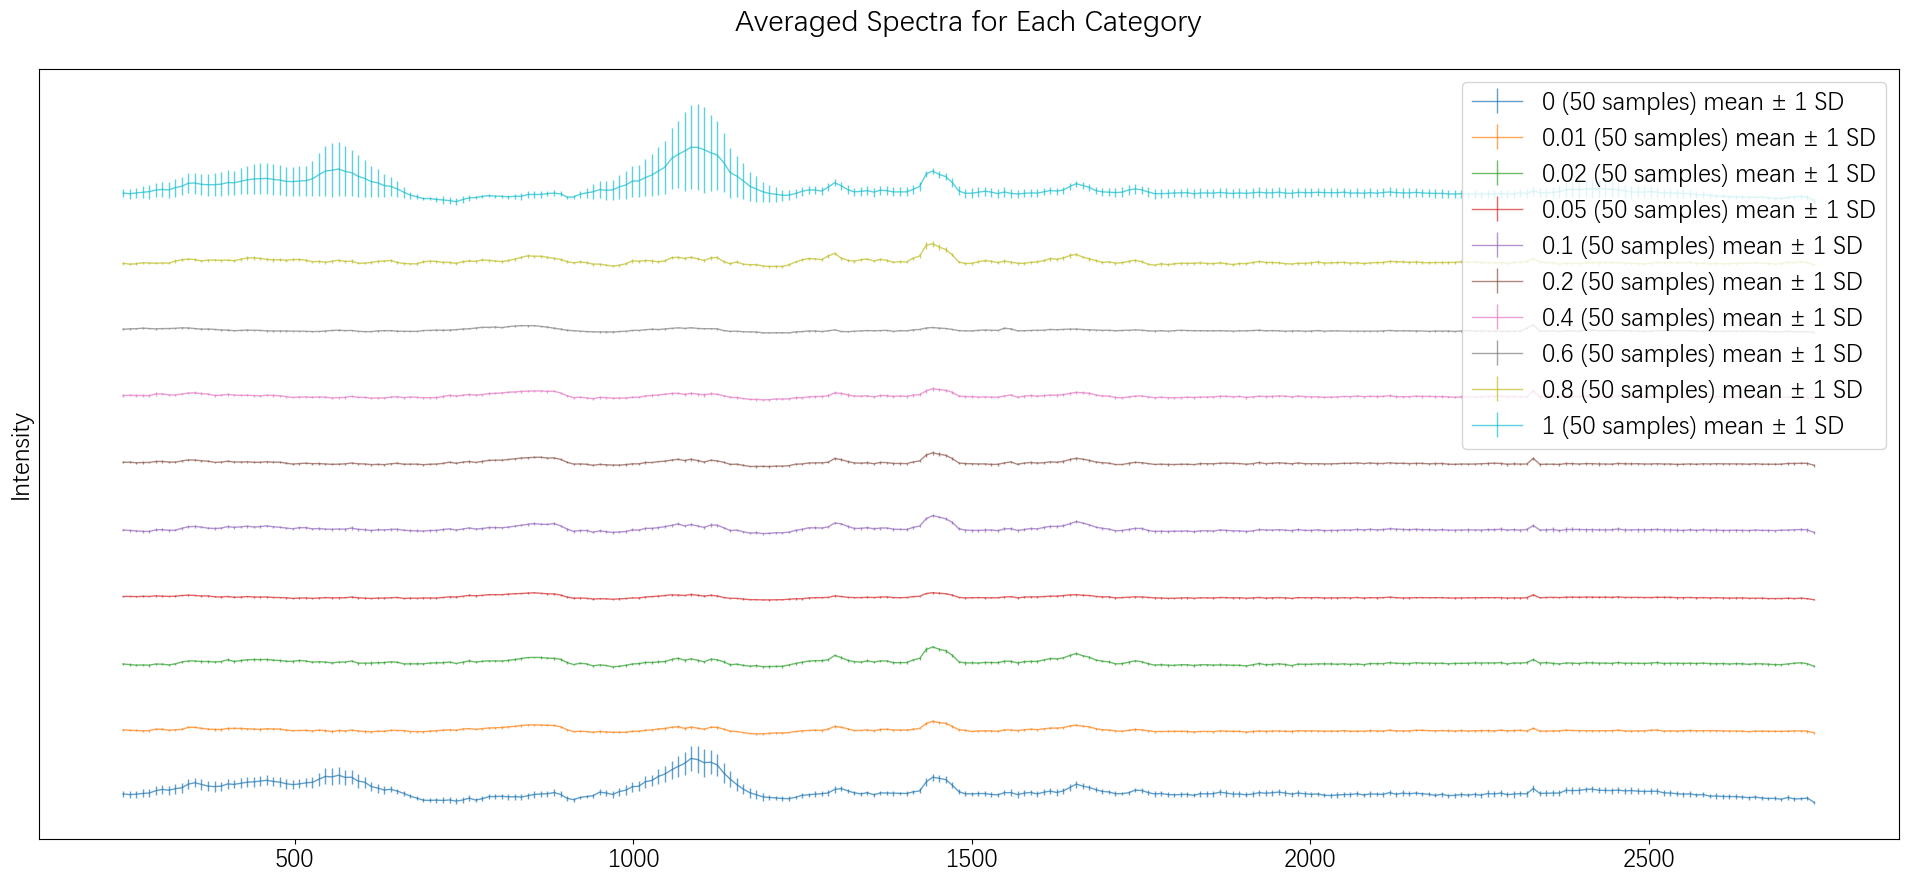

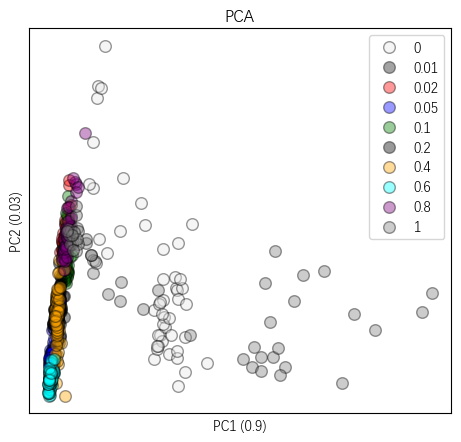

In [2]:
from qsi import io
X, yc, X_names, _, labels = io.load_dataset('milk_adulteration', x_range = list(range(100,1400)), shift=200)

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, pres = [('max', 0.2),('baseline_removal', (1e7, 1e-2))])
io.draw_class_average(X, yc, X_names, labels=labels, SD=1, shift=800)
_ = io.scatter_plot(X, yc, labels=labels)

In [3]:
labels

['0', '0.01', '0.02', '0.05', '0.1', '0.2', '0.4', '0.6', '0.8', '1']

In [4]:
import numpy as np
y = np.asfarray(np.array(labels)[yc]) # convert class label to continuous value

# Stratified Kennardstone Split

保持分割后的数据集在y上的分布相同

参考： https://hxhc.xyz/post/kennardstone-spxy/

In [5]:
from sklearn.utils import shuffle
X, yc = shuffle(X, yc)

In [6]:
from qsi.io.pre import stratified_kennardstone_split # kennardstone_split

X_cal, X_test, y_cal, y_test = stratified_kennardstone_split(X, yc, 0.15)
X_train, X_val, y_train, y_val = stratified_kennardstone_split(X_cal, y_cal, 0.2)
y_train = np.asfarray(np.array(labels)[y_train])
y_val = np.asfarray(np.array(labels)[y_val])
y_test = np.asfarray(np.array(labels)[y_test])

In [7]:
y_train.shape, y_val.shape, y_test.shape

((340,), (80,), (80,))

# Regression

In [8]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'DejaVu Sans'


def draw_regression_plots(yt, yp, title, order=False):
    '''
    yt : ground truth
    yp : prediction
    order : if true, will sort points by yt.
    '''

    if order:
        idx = sorted(range(len(yt)), key=lambda k: yt[k])
        yp = np.array(yp)[idx] # order yp by yt
        yt = np.array(yt)[idx]
        
    # scatter plot
    plt.figure()
    plt.title(title + '\n' + 'R2 =' + str(round(r2_score(yt, yp),3)) + ', MSE =' + str(round(mean_squared_error(yt, yp),3)))
    plt.scatter(range(len(yt)), yt, label = 'ground truth')
    plt.scatter(range(len(yp)), yp, label='prediction')
    plt.legend()
    plt.show()


    # diagonal scatter plot 
    plt.figure(figsize = (6,6))
    plt.scatter(yt, yp)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()
    
    # residual plot
    residuals = yt - yp
    plt.figure()
    plt.scatter(yt, residuals)
    plt.xlabel('True values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Residuals')
    plt.show()

Training set R2:  0.9717543403654387
Test set R2: 0.2748175704571173


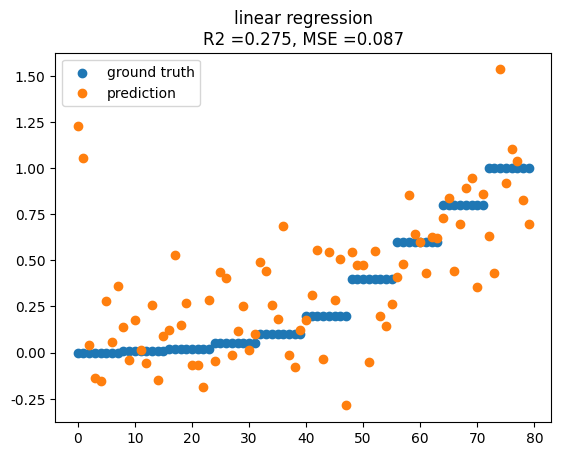

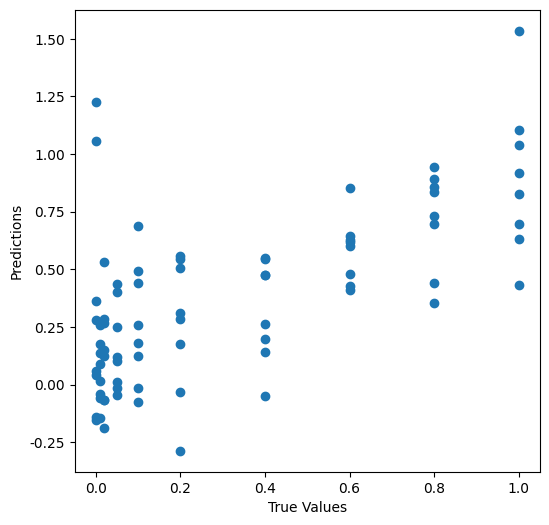

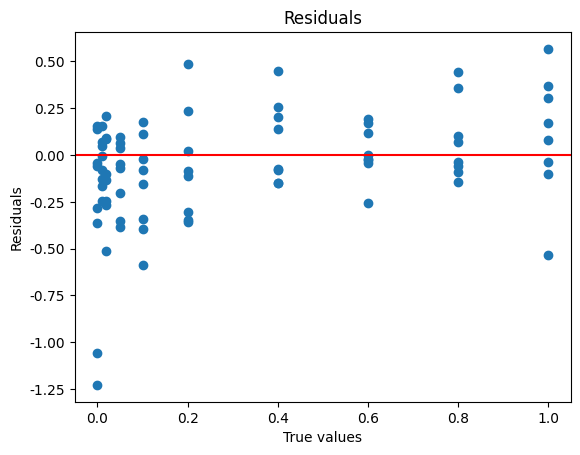

In [9]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

lr = LinearRegression()
yp = lr.fit(X_train, y_train).predict(X_test)

y_pred_train = lr.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))
print('Test set R2:', r2_score(y_test, yp))

draw_regression_plots(y_test, yp, title = 'linear regression')

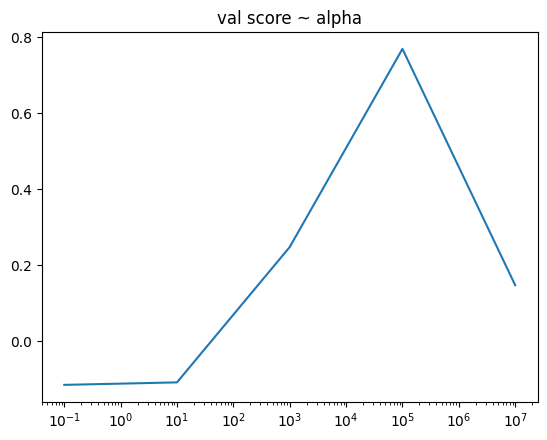

Training set R2:  0.8476886593685871
Test set R2: 0.7844419117086567


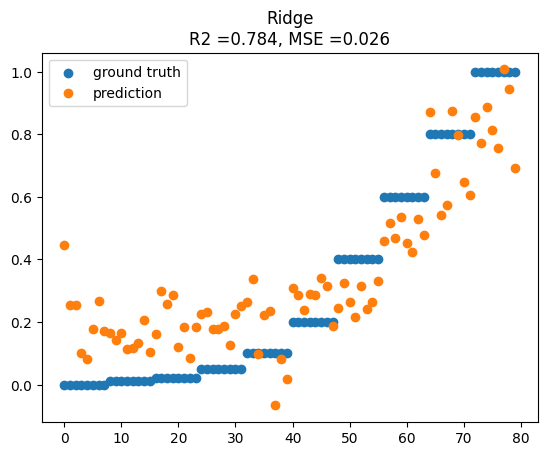

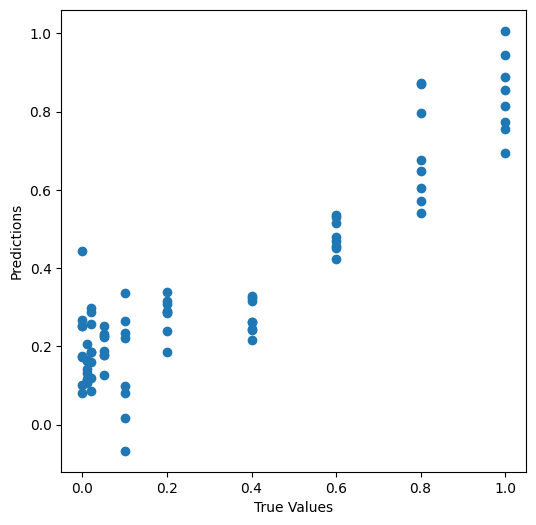

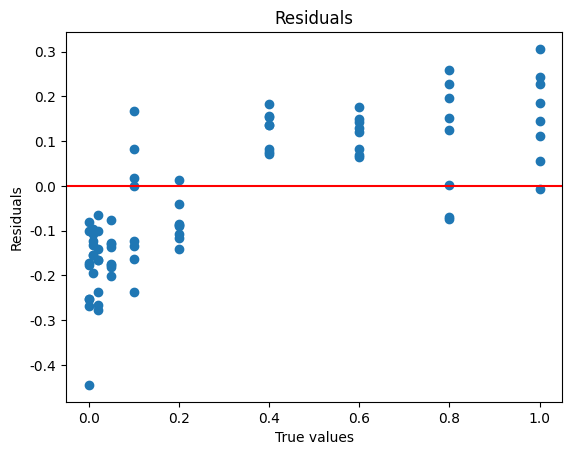

In [10]:
# Ridge
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

hparams = [.1, 10, 1000, 100000, 10000000]
val_scores = []
for alpha in hparams:
    ridge = Ridge(alpha = alpha).fit(X_train, y_train)
    val_scores.append(ridge.score(X_val, y_val))

plt.title('val score ~ alpha')
plt.xscale('log')
plt.plot(hparams, val_scores)
plt.show()

best_hparam = hparams[np.argmax(val_scores)]
ridge = Ridge(alpha = best_hparam).fit(X_train, y_train)

# print('test score:', ridge.score(X_test, y_test))
yp = ridge.predict(X_test)

y_pred_train = ridge.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))
print('Test set R2:', r2_score(y_test, yp))

draw_regression_plots(y_test, yp, title = 'Ridge')

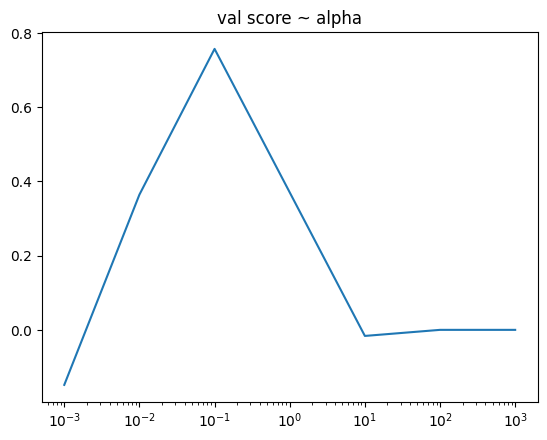

Training set R2:  0.873129125882419
Test set R2: 0.779868541783578


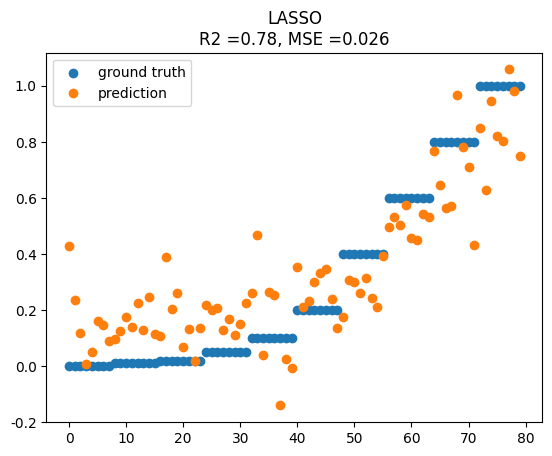

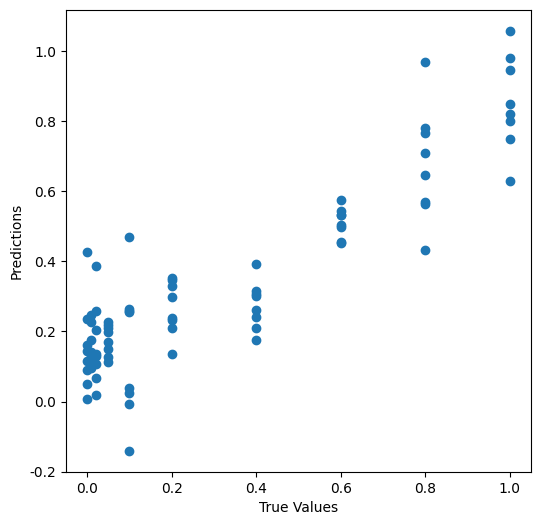

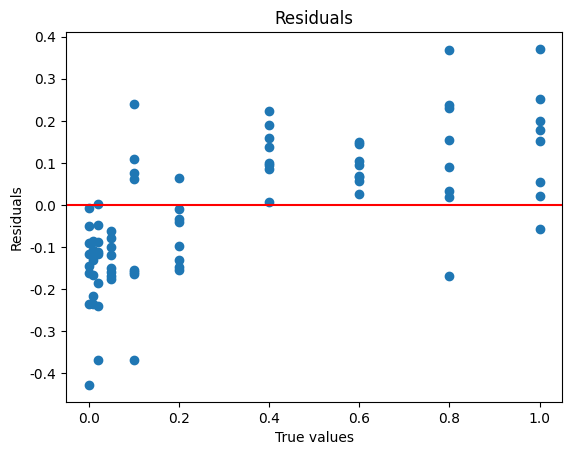

In [11]:
# LASSO
from sklearn.linear_model import Lasso, LassoCV
import matplotlib.pyplot as plt


hparams = [.001, .01, .1, 10, 100, 1000]
val_scores = []
for alpha in hparams:
    lasso = Lasso(alpha = alpha).fit(X_train, y_train)
    val_scores.append(lasso.score(X_val, y_val))

plt.title('val score ~ alpha')
plt.xscale('log')
plt.plot(hparams, val_scores)
plt.show()

best_hparam = hparams[np.argmax(val_scores)]
lasso = Lasso(alpha = best_hparam).fit(X_train, y_train)

lasso = Lasso(alpha = 0.1).fit(X_train, y_train)
yp = lasso.predict(X_test)

y_pred_train = lasso.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))
print('Test set R2:', r2_score(y_test, yp))

draw_regression_plots(y_test, yp, title = 'LASSO')

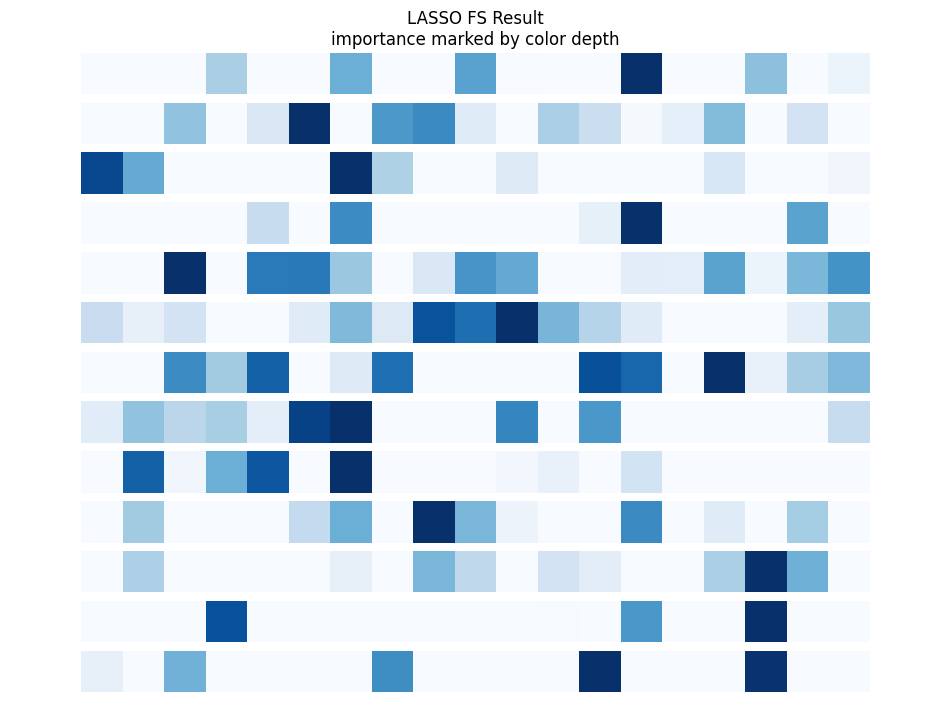

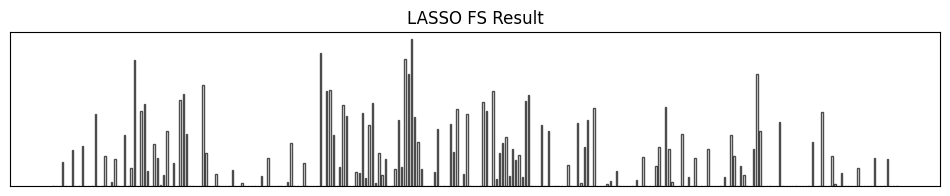

Important feature Number:  120
Important features indices:  [110  82 108  25 109 216  46  85 135  84  40 146  39 145 132  98  28  89
 188 166 124 133  27 236  95 127  13  90 111 164 106 223 161 122  97 150
 118  35 152 217  41 193 208  22  86 139 112 233 138  73  31   9 186 163
 215 141 189 201   6 123 137 100  47 143 209  16 239 181  32 197 252  66
 256 102  19 142   3  77  37 158 211 185  88 107  24 247 113 105  55  29
 173 117  93 242  94  50 126 101 212  34 140  64 195 144 206  96 136 179
 171 190  18  72  99  58 162 170 240  33  10 231]
Important features names:  [1307.231  1037.246  1287.947   487.6329 1297.589  2329.319   690.1219
 1066.173  1548.29   1056.531   632.2679 1654.355   622.6256 1644.713
 1519.363  1191.523   516.5599 1104.742  2059.333  1847.202  1442.224
 1529.005   506.9176 2522.166  1162.596  1471.151   371.9249 1114.385
 1316.874  1827.917  1268.662  2396.815  1798.99   1422.939  1181.881
 1692.925  1384.37    584.0563 1712.209  2338.961   641.9103 2107.545
 225

In [12]:
from qsi.vis import plot_feature_importance

fi = np.abs(lasso.coef_)
plot_feature_importance(fi, X_names, 'LASSO FS Result')

N = (fi!=0).sum()
idx = (np.argsort(fi)[-N:])[::-1]
X_s = X[:, idx]
print('Important feature Number: ', len(idx))
print('Important features indices: ', idx)
if X_names is not None:
    print('Important features names: ', np.array(X_names)[idx])
print('Top-'+str(len(idx))+' feature Importance: ', fi[idx])

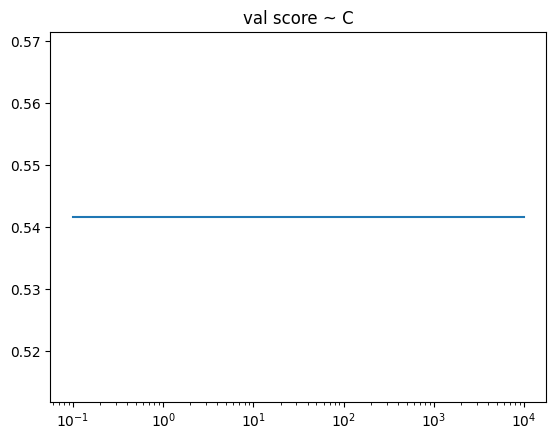

Training set R2:  0.9367584819128683
Test set R2: 0.6641207808375189


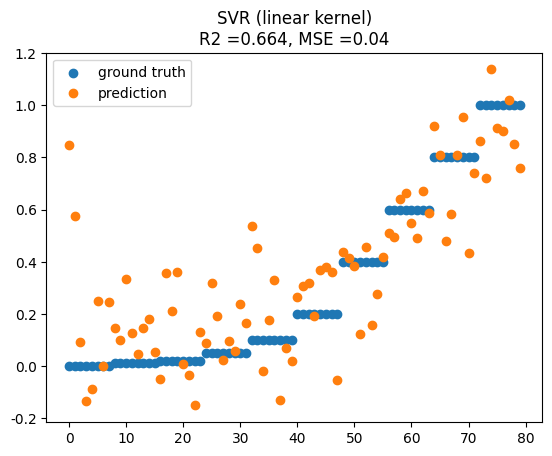

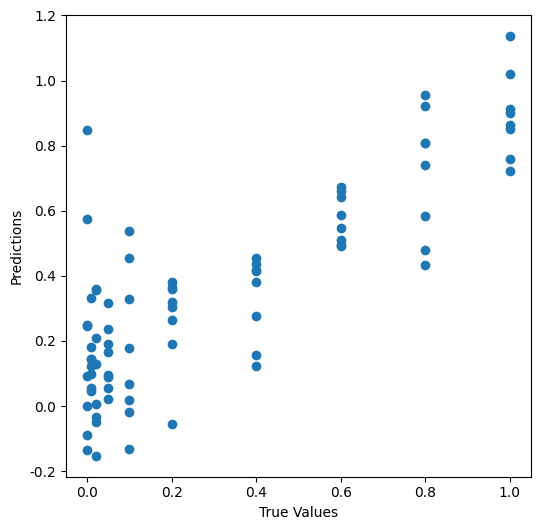

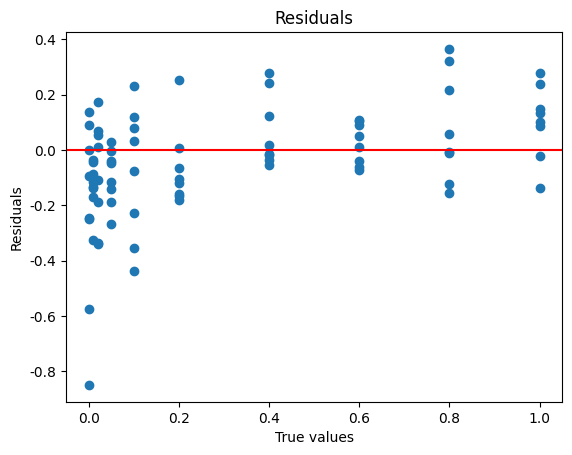

In [13]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Cs = [ .1, 10, 100, 1000, 10000]
val_scores = []
for C in Cs:
    svr = SVR(kernel = 'linear', C=C).fit(X_train, y_train)
    val_scores.append(svr.score(X_val, y_val))

plt.title('val score ~ C')
plt.xscale('log')
plt.plot(Cs, val_scores)
plt.show()

best_hparam = Cs[np.argmax(val_scores)]
svr = SVR(kernel = 'linear', C=best_hparam)
yp = svr.fit(X_train, y_train).predict(X_test)

y_pred_train = svr.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))
print('Test set R2:', r2_score(y_test, yp))

draw_regression_plots(y_test, yp, title = 'SVR (linear kernel)')

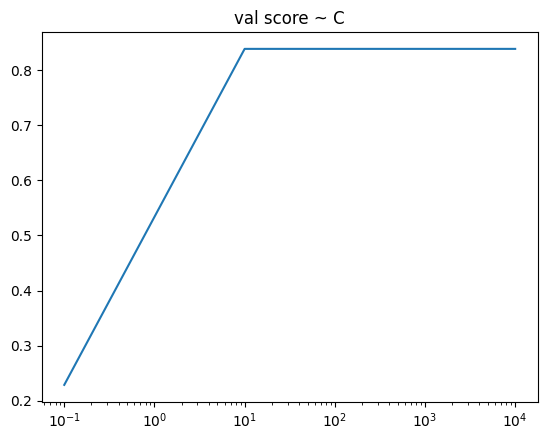

Training set R2:  0.9437112615315095
Test set R2: 0.883885475566917


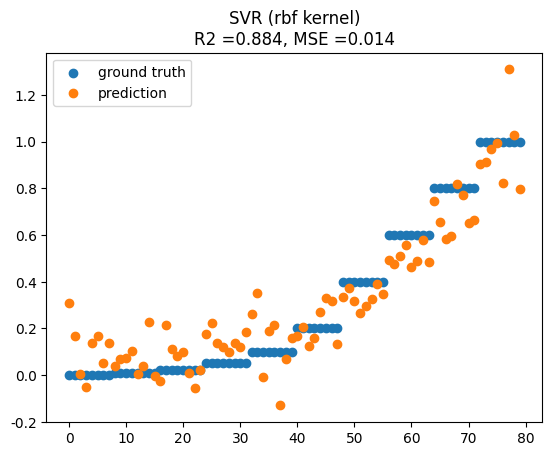

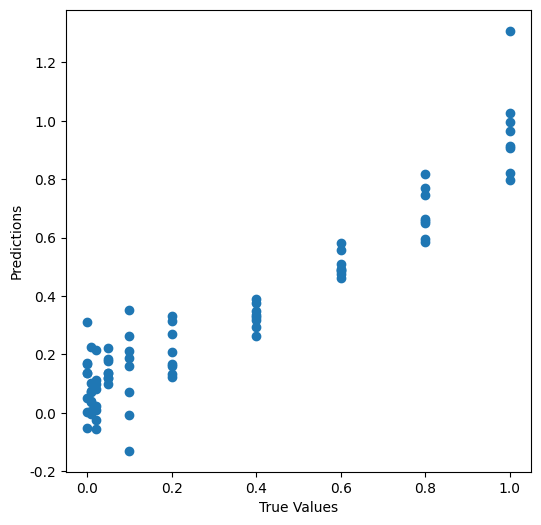

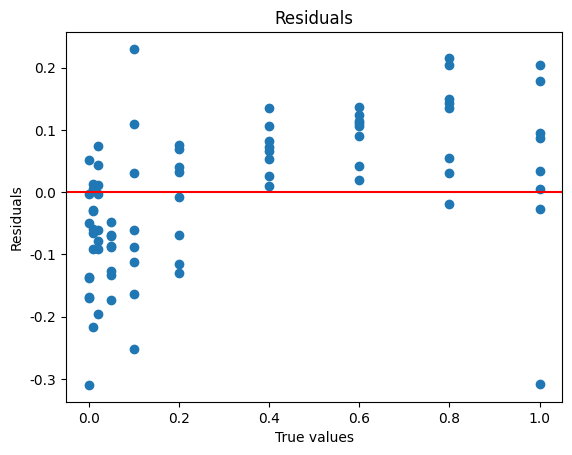

In [14]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt


Cs = [ .1, 10, 100, 1000, 10000]
val_scores = []
for C in Cs:
    svr = SVR(kernel = 'rbf', C=C).fit(X_train, y_train)
    val_scores.append(svr.score(X_val, y_val))

plt.title('val score ~ C')
plt.xscale('log')
plt.plot(Cs, val_scores)
plt.show()

best_hparam = Cs[np.argmax(val_scores)]
svr = SVR(kernel = 'rbf', C=best_hparam)
yp = svr.fit(X_train, y_train).predict(X_test)

y_pred_train = svr.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))
print('Test set R2:', r2_score(y_test, yp))

draw_regression_plots(y_test, yp, title = 'SVR (rbf kernel)')

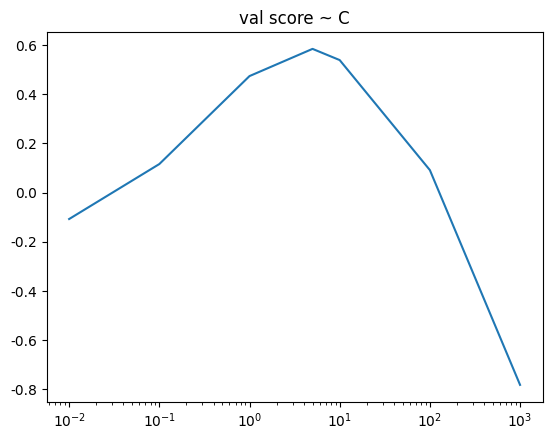

Training set R2:  0.7790098211730062
Test set R2: 0.5610912568719024


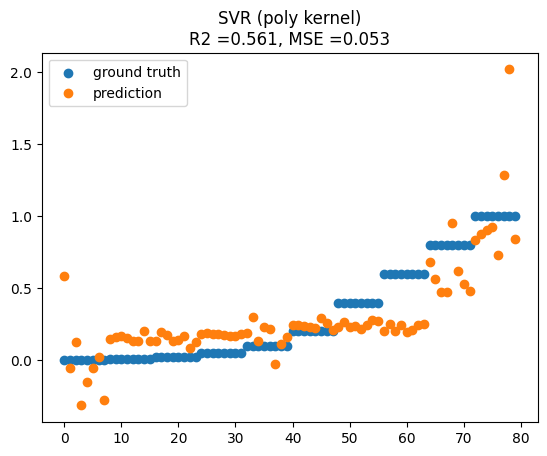

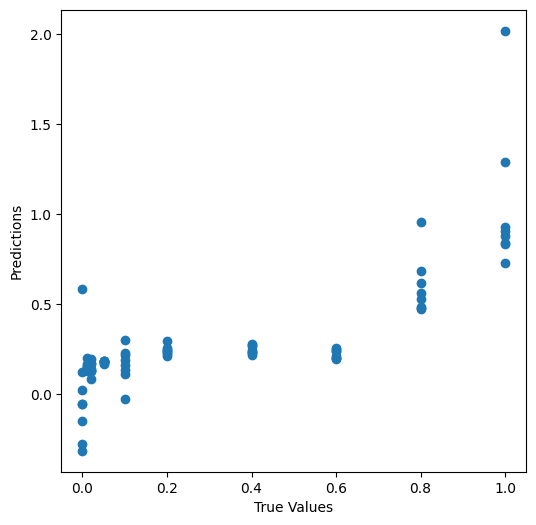

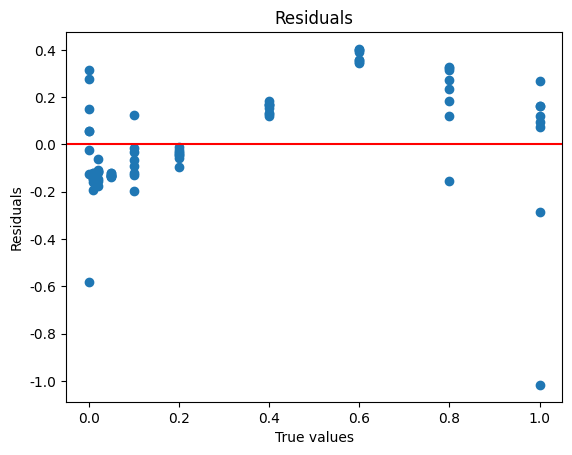

In [15]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt

Cs = [.01, .1, 1, 5, 10, 100, 1000]
val_scores = []
for C in Cs:
    svr = SVR(kernel = 'poly', C=C).fit(X_train, y_train)
    val_scores.append(svr.score(X_val, y_val))

plt.title('val score ~ C')
plt.xscale('log')
plt.plot(Cs, val_scores)
plt.show()

best_hparam = Cs[np.argmax(val_scores)]
svr = SVR(kernel = 'poly', C=best_hparam)
yp = svr.fit(X_train, y_train).predict(X_test)

y_pred_train = svr.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))
print('Test set R2:', r2_score(y_test, yp))

draw_regression_plots(y_test, yp, title = 'SVR (poly kernel)')

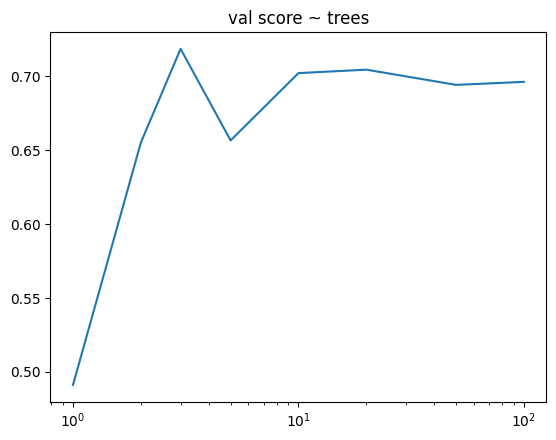

Training set R2:  0.6066372525029774
Test set R2: 0.6407354644176891


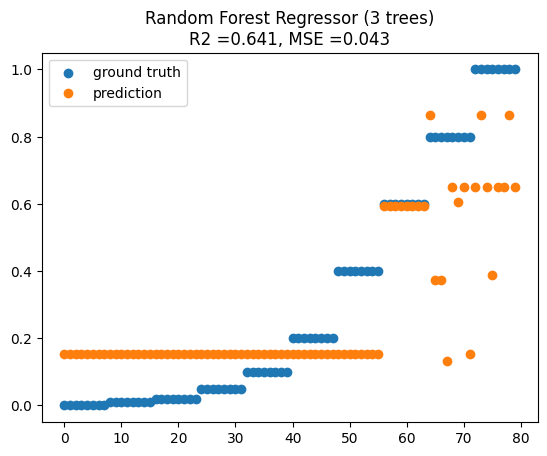

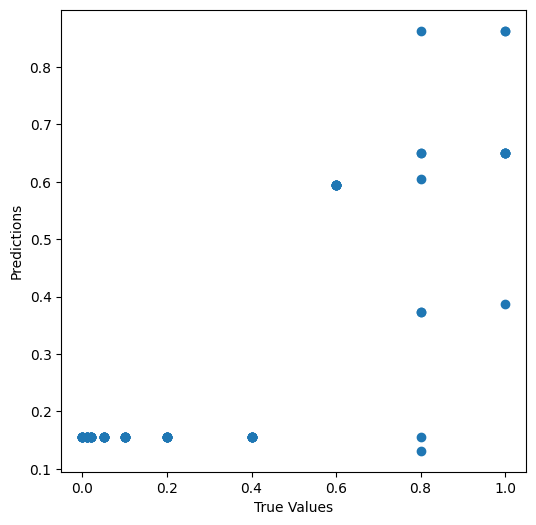

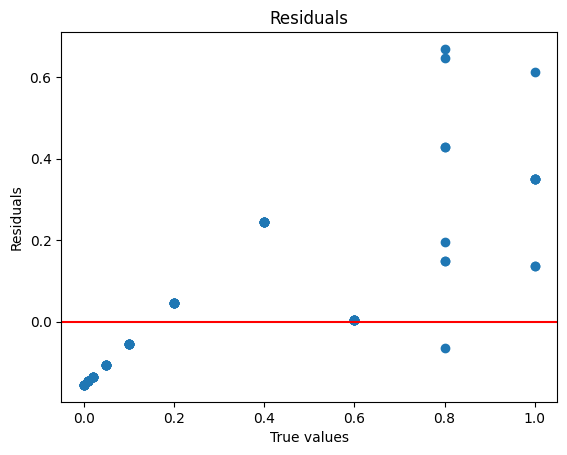

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

# Each run is random. The result is very unstable

Ns = [1, 2, 3, 5, 10, 20, 50, 100]
val_scores = []
for N in Ns:
    rf_regressor = RandomForestRegressor(n_estimators = N, max_depth = 2).fit(X_train, y_train)
    val_scores.append(rf_regressor.score(X_val, y_val))

plt.title('val score ~ trees')
plt.xscale('log')
plt.plot(Ns, val_scores)
plt.show()

best_hparam = Ns[np.argmax(val_scores)]
rf_regressor = RandomForestRegressor(n_estimators = best_hparam, max_depth = 2)
rf_regressor.fit(X_train, y_train)

y_pred_train = rf_regressor.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))

y_pred = rf_regressor.predict(X_test)
print('Test set R2:', r2_score(y_test, y_pred))

draw_regression_plots(y_test, y_pred, title = 'Random Forest Regressor (' + str(best_hparam) + ' trees)')

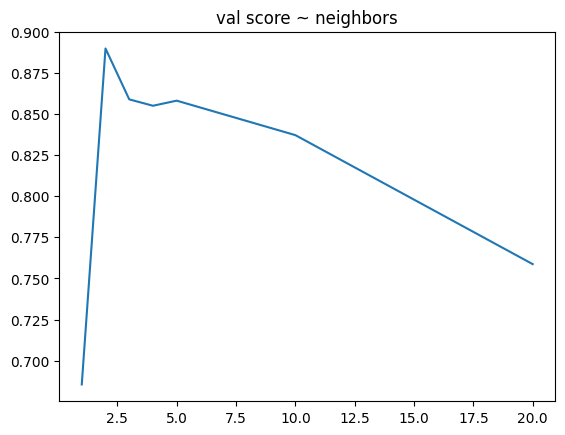

Training set R2:  0.9280821951334122
Test set R2: 0.857157419118626


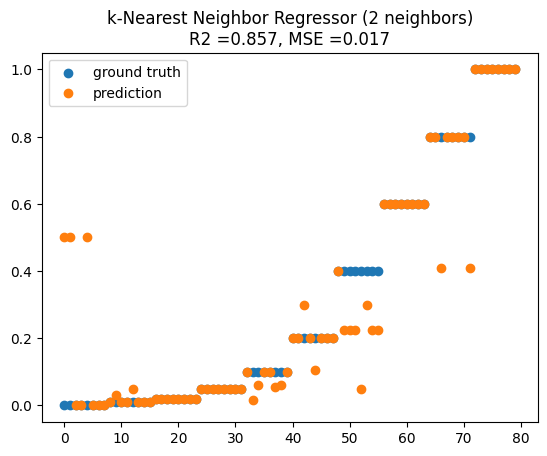

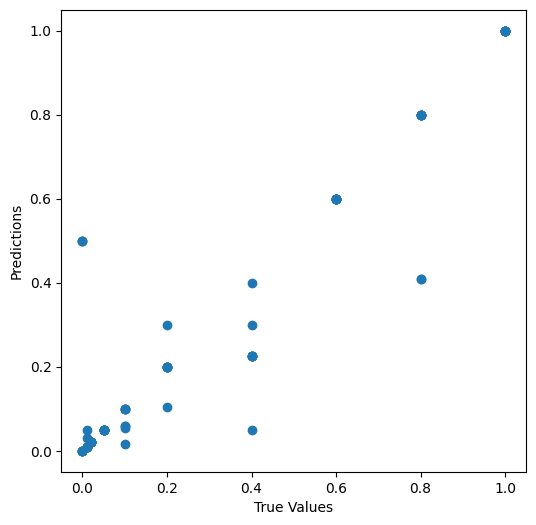

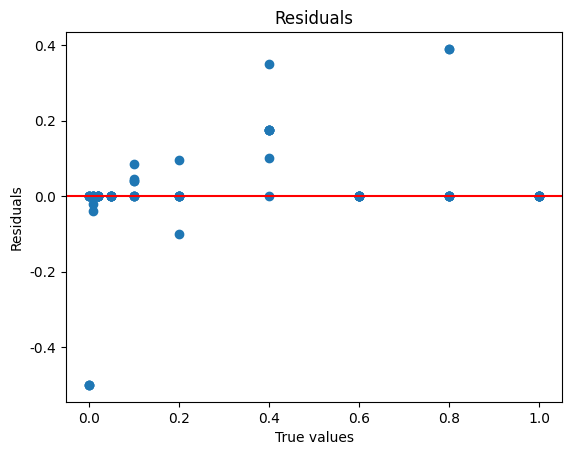

In [17]:
from sklearn.neighbors import KNeighborsRegressor

# param_grid = {
#     'n_neighbors': [1, 2, 3, 4, 5, 10],
#     'metric': ['l1', 'l2', 'chebyshev', 'cosine'], # l1 - manhattan / cityblock, l2 - euclidean 
#}

Ns = [1, 2, 3, 4, 5, 10, 20]
val_scores = []
for N in Ns:
    knr = KNeighborsRegressor(n_neighbors = N).fit(X_train, y_train)
    val_scores.append(knr.score(X_val, y_val))

plt.title('val score ~ neighbors')
# plt.xscale('log')
# .set_major_locator(MaxNLocator(integer=True))
plt.plot(Ns, val_scores)
plt.show()

best_hparam = Ns[np.argmax(val_scores)]

knr = KNeighborsRegressor(n_neighbors = best_hparam).fit(X_train, y_train) 

y_pred_train = knr.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))

y_pred = knr.predict(X_test)
print('Test set R2:', r2_score(y_test, y_pred))

draw_regression_plots(y_test, y_pred, title = 'k-Nearest Neighbor Regressor (' + str(best_hparam) +' neighbors)')

25it [00:11,  2.15it/s]


Training set R2:  0.9992738648511716
Test set R2: 0.9268095086134928


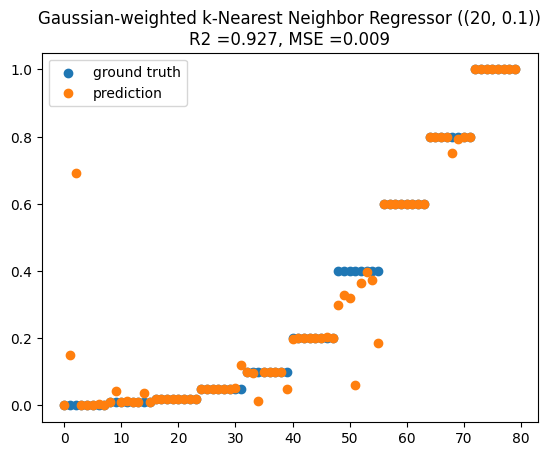

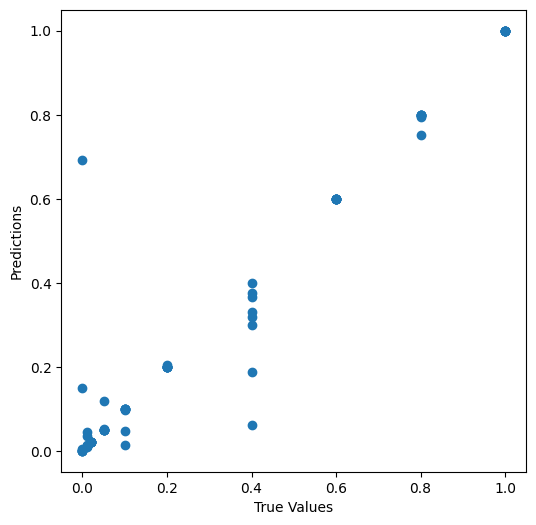

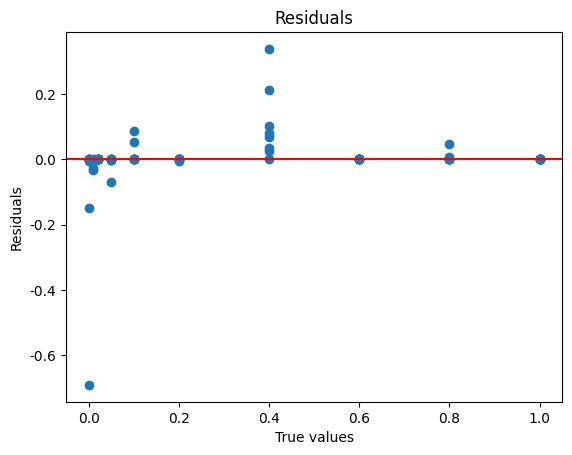

In [14]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
import itertools
from tqdm import tqdm

class GaussianWeightedKNNRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self, n_neighbors=10, sigma=1.0, epsilon=0.5):
        self.n_neighbors = n_neighbors
        self.sigma = sigma
        self.epsilon = epsilon
        self.knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.knn.fit(X_train, y_train)
    
    def _gaussian_weights(self, distances):
        distances = np.where(distances == 0, self.epsilon, distances)  # 将距离为0的位置替换为epsilon
        #print("Distances:", distances)
        #distances /= 100  # 将距离除以100
        #print("Distances:", distances)
        weights = np.exp(-distances**2 / (2 * self.sigma**2))
        #print("Weights:", weights)
        return weights
    
    def predict(self, X):

        predictions=[]
        
        for query_point in X:
            #print("X", X)
            distances, indices = self.knn.kneighbors(query_point.reshape(1, -1))
            weights = self._gaussian_weights(distances/np.max(distances))
            normalized_weights = weights / np.sum(weights)
            weighted_sum = np.sum(normalized_weights * self.y_train[indices.flatten()])
            predictions.append(weighted_sum)
            
        return np.array(predictions)

    def score(self, X, y):
        return r2_score(y, self.predict(X))
    
    def gridsearch_hparam(X_train, y_train, X_val = None, y_val = None, ks = [3, 4, 5, 10, 20], sigmas=[.1, 1, 10,100,1000]):
        
        best_r2 = -np.inf
        best_clf = None
        best_predictions = None

        hparams = [ks, sigmas]
        
        for k, sigma in tqdm(itertools.product(*hparams)):
            
            clf = GaussianWeightedKNNRegressor(k, sigma)

            if X_val is None or y_val is None:
                X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, shuffle=True, random_state=0)
            clf.fit(X_train, y_train)
            
            score = r2_score(y_val, clf.predict(X_val))            

            # print(k, sigma, score)
            if score > best_r2:
                best_r2 = score
                best_clf = clf
        
        return best_clf

gwknr = GaussianWeightedKNNRegressor.gridsearch_hparam(X_train, y_train, X_val, y_val) 
# print(gwknr.__dir__)
best_hparam = gwknr.n_neighbors, gwknr.sigma

y_pred_train = gwknr.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))

y_pred = gwknr.predict(X_test)
print('Test set R2:', r2_score(y_test, y_pred))

draw_regression_plots(y_test, y_pred, title = 'Gaussian-weighted k-Nearest Neighbor Regressor (' + str(best_hparam) +')')

## Summary

    Regressor	R2	MSE
    linear regression	0.275	0.087
    ridge	0.784	0.026
    LASSO	0.78	0.026
    SVR(linear)	0.664	0.04
    SVR(rbf)	0.884	0.014
    SVR(poly)	0.534	0.056
    Random Forest Regressor	0.769	0.028
    K-Neighbors Regressor	0.857	0.017
    Gaussian Weighted K-Neighbors Regressor	0.927	0.009